In [ ]:
### INFX575 Group Project: Preliminary data analysis

In [74]:
#0.  Setup
# Numpy for working with Arrays
import numpy as np
# Pandas for working with data tables
import pandas as pd
# SciPy implements many different numerical algorithms
import scipy as sp
import scipy.stats as stats
# Module for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Module for pretty plotting
import seaborn as sns
# Module for linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Pump it Up: Data Mining the Water Table 
Team members: Anya, Ashwin, Brett, Wenhong  

Hosted by DrivenData.org    
Source: https://www.drivendata.org/competitions/7/

## Preliminary Data Analysis

---

### Loading data
DrivenData.org provided 3 datasets:  
1. Training set values - the independent variables for the training set  
2. Training set labels - the dependent variable for the training set
3. Test set values - the independent variables that need prediction

We merged dataset \#1 and \#2 into Pandas dataframe named 'water'.  'Water' will be used throughout the project as the data for machine learning purposes.  After the preliminary analysis, we will split 'water' into a training set for training algorithms and a validation set for testing the performance of our predictions (unseen during training phase).  In the final stage, we will use dataset \#3 as the actual testing set for making actual predictions and submit our results to DrivenData.org as part of the competition.

In [3]:
### load data from csv files
water_values = pd.read_csv('../train_set_values.csv')
water_labels = pd.read_csv('../train_set_labels.csv')

In [9]:
### merge values and labels
water = pd.merge(water_values, water_labels, on='id')
print "Merged dataset dimensions: ", water.shape[0], "observations, ", water.shape[1], "variables"
#preview merged data
water.head()

Merged dataset dimensions:  59400 observations,  41 variables


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### 1. What information/features/characteristics do you have for each observation? 
'Water' dataset include numeric and non-numeric variables.

In [59]:
print "All numeric variables: \n", list(water.select_dtypes(include=[np.number]).columns.values)
print "\nAll non-numeric variables: \n", list(water.select_dtypes(exclude=[np.number]).columns.values)

All numeric variables: 
['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

All non-numeric variables: 
['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group']


Response variable: 'status_group' - categorical data with 3 possible values:
- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

Predictor variables: we will evaluate all the other features and determine which should be used as input variables.

Summary of numeric features:  
- id - a uniqued identifier of each waterpoint
- amount_tsh - quantitative, total static head, or amount water available to waterpoint
- gps_height, longitude, latitude - geographical 3D coordinates
- num_private - no description provided, values range from 0 to 1776
- region_code, district_code - categorical, regions and districts of Tanzania
- population - quantitative, population around the well, units not specified
- construction_year - quantitative or categorical, Year the waterpoint was constructed, range from 1960 to 2013 

-Summary of non-numeric features: 
- wpt_name - name of waterpoint, if exists, 'none' if doesn't
- waterpoint_type, waterpoint_type_group - categorical, the kind of waterpoint, i.e. 'communal standpipe', most redundant values
- date_recorded - metadata, row entered date
- recorded_by - metadata, group entering data, all values equal 'GeoData Consultants Ltd.'
- funder, installer - categorical, organizations that created the well
- basin, region, lga, ward, subvillage - categorical, geographical locations, hierarchical order
- public_meeting, permit - boolean True/False
- extraction_type_class, extraction_type_group, extraction_type - categorical, kind of extraction, hierarchical order
- scheme_management, scheme_name - categorical, who operates the waterpoint, hierarchical order
- management_group, management - categorical, how the waterpoint is managed (note: 'management' and 'scheme_management' many redundant values)
- payment, payment_type - categorical, payment arrangements, note: most redundant values
- water_quality, quality_group - categorical, the quality of water, note: most redundant values
- quantity, quantity_group - categorical, the quantity of water, note: all redundant values
- source_class - categorical, the source of water, values: 'groundwater', 'surface', 'unknown'
- source_type, source - categorical, the source of water, most redundant values

Refer to Appendix A for the list of features for each waterpoint as provided by DrivenData.org at https://www.drivendata.org/competitions/7/page/25/#features_list.

### 3. Are there obvious trends in the data (over time, across subgroups, etc.), and are the differences statistically significant?

First, we will explore trends over time, by using 'construction_year' as temporal predictor.

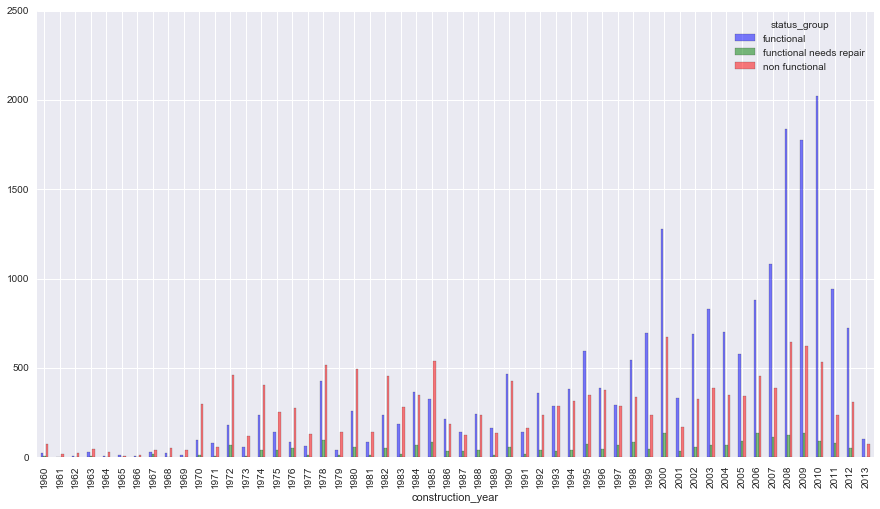

In [88]:
### explore trends over time 
# status by year - 3 options to draw: 

# option 1) vertical bars, not stacked
plt.rc('figure', figsize=(15, 8))
water_region_grouped = water[water.construction_year!=0].groupby('construction_year').status_group.value_counts()
g=water_region_grouped.unstack().plot(kind='bar', alpha=0.5)


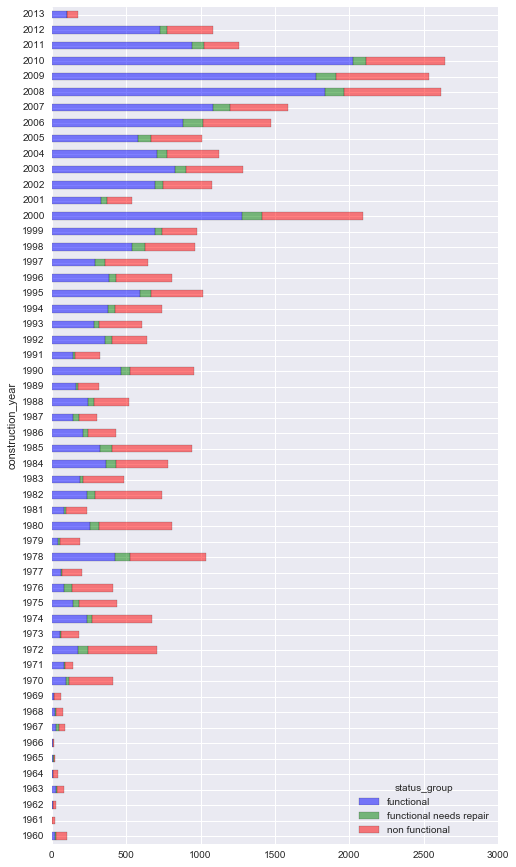

In [85]:
# status by year
# option 2) horizontal bars, stacked
plt.rc('figure', figsize=(8, 15))
water_region_grouped = water[water.construction_year!=0].groupby('construction_year').status_group.value_counts()
g=water_region_grouped.unstack().plot(kind='barh', stacked=True, alpha=0.5)

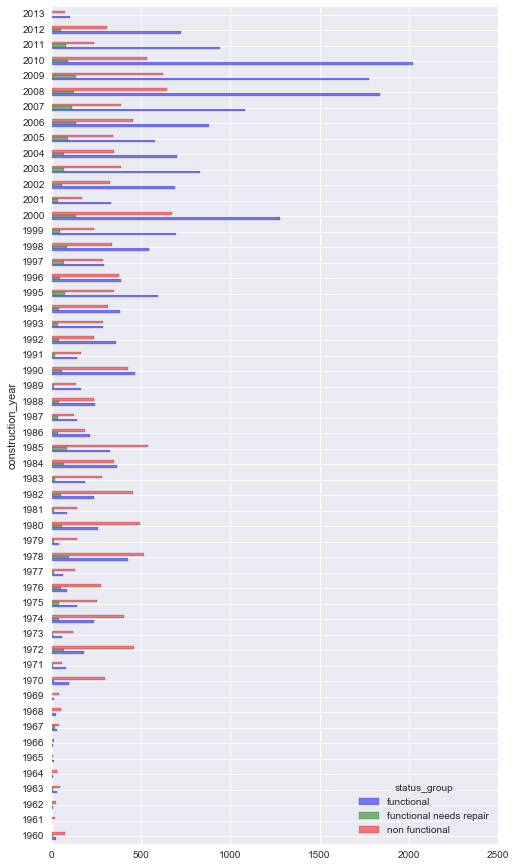

In [86]:
# status by year
# option 3) horizontal bars, not stacked
g=water_region_grouped.unstack().plot(kind='barh', alpha=0.5)

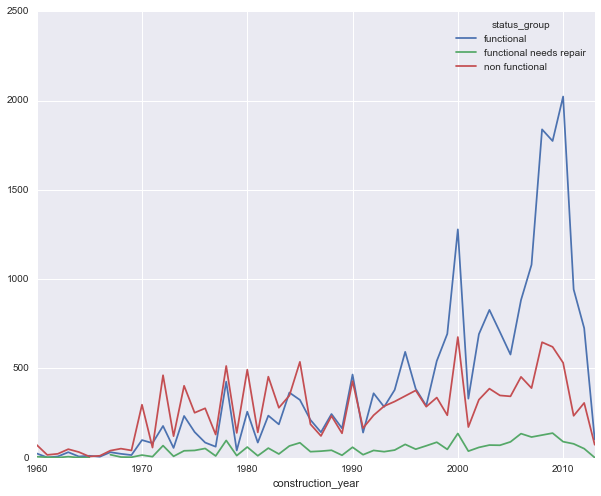

In [89]:
# status by date - default plot
plt.rc('figure', figsize=(10, 8))
g=water_region_grouped.unstack().plot()

Exploring data by region.  The highest level of regionality is by 'basin'

Basins: 
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
dtype: int64


(<matplotlib.figure.Figure at 0x119f8ba90>,
 OrderedDict([(('Lake Nyasa', 'functional'), (0.0, 0.0, 0.08231351981351981, 0.64935826056379298)), (('Lake Nyasa', 'non functional'), (0.0, 0.65266951884193858, 0.08231351981351981, 0.29518060520815015)), (('Lake Nyasa', 'functional needs repair'), (0.0, 0.95116138232823455, 0.08231351981351981, 0.048838617671765366)), (('Lake Victoria', 'functional'), (0.08712121212121211, 0.0, 0.16588966588966592, 0.49436233075360198)), (('Lake Victoria', 'non functional'), (0.08712121212121211, 0.49767358903174763, 0.16588966588966592, 0.40314763404004528)), (('Lake Victoria', 'functional needs repair'), (0.08712121212121211, 0.90413248134993862, 0.16588966588966592, 0.095867518650061212)), (('Pangani', 'functional'), (0.25781857031857036, 0.0, 0.1447163947163947, 0.59691541846304275)), (('Pangani', 'non functional'), (0.25781857031857036, 0.60022667674118846, 0.1447163947163947, 0.34345970932041414)), (('Pangani', 'functional needs repair'), (0.257818570

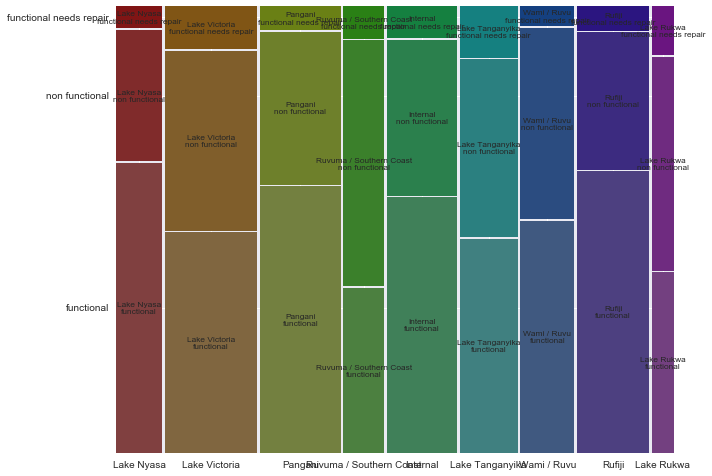

In [98]:
#draw mosaic plot - example waterpoint type by basin
print "Basins: \n", water.basin.value_counts()

#mosaic plot
from statsmodels.graphics.mosaicplot import mosaic
mosaic(water, ['basin','status_group'])

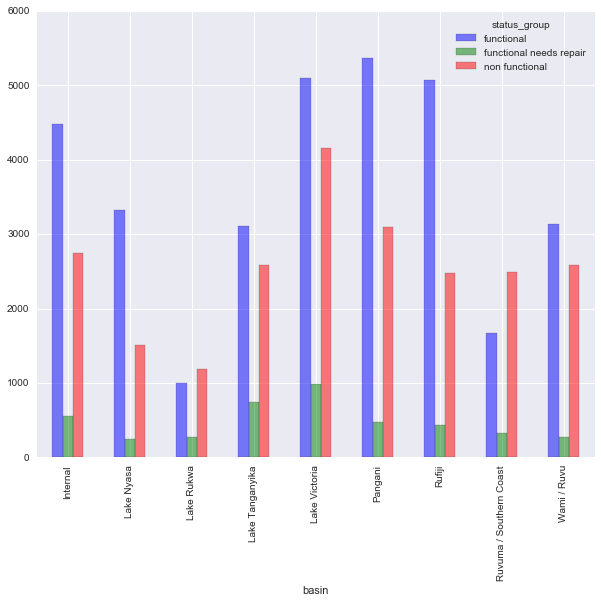

In [101]:
#same status by basin
water_region_grouped = water.groupby('basin').status_group.value_counts()
water_region_grouped.unstack().plot(kind='bar', alpha=.5)

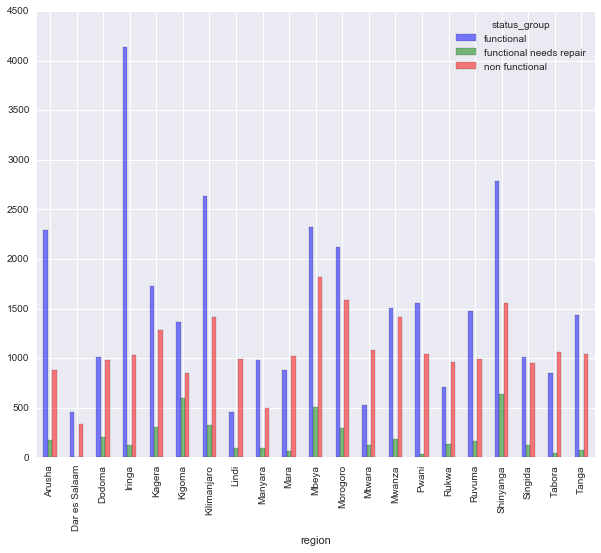

In [94]:
### continue with waterpoints by region
#group by region + status_group, draw a bar graph
water_region_grouped = water.groupby('region').status_group.value_counts()
water_region_grouped.unstack().plot(kind='bar', alpha=.5)


In [106]:
#same by basin, region - facet grid?


In [69]:
# set date_recorded to date/time
water['date_recorded'] = pd.to_datetime(water['date_recorded'])

# set all categorical values to category: based on having fewer than 50 unique values
for c in water:
    if water[c].dtypes == 'O':
        if len(water[c].unique()) < 50:
            water[c] = water[c].astype('category')

# see columns set as type 'category'
water.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                          category
subvillage                       object
region                         category
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                        int64
public_meeting                 category
recorded_by                    category
scheme_management              category
scheme_name                      object
permit                         category
construction_year                 int64
extraction_type                category


## Appendix A.  DataDriven.org Documentation

### List of features for each observation
- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint



## Extra Snippets - delete before submission